In [1]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin')>

In [2]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Dataset generator
n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 0.25
shift       = pred_dim
batch_size  = 16
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch']
                )

In [6]:
Data.Train.element_spec

(TensorSpec(shape=(None, 1200, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

In [7]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [8]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

In [9]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 3]
Output dim: [1, 1]


In [10]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [46]:
class EncDec(tf.keras.Model):
    def __init__(self, enc_units, dec_units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.enc_units = enc_units
        self.dec_units = dec_units

        # Encoder cells
        self.encoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.enc_units]
        self.encoder_stacked = tf.keras.layers.StackedRNNCells(self.encoder_cells)
        self.encoder_rnn = tf.keras.layers.RNN(self.encoder_stacked, return_state=True)
#         self.enc_dense = tf.keras.layers.Dense(INPUT_DIM[-1])

        # Decoder cells
        self.decoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.dec_units]
        self.dense = tf.keras.layers.Dense(OUTPUT_DIM[-1])

    def warmup(self, inputs):
        
        out = self.encoder_rnn(inputs)
#         x = self.enc_dense(out[0])
        x = inputs[:,-1:,0]
        
        return x, out[1:]

    def call(self, inputs, training=True):
        
        predictions = []
        
        prediction, states = self.warmup(inputs)

        # Insert the first prediction.
#         predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(0, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            states_ = []
            
            for i in range(0, len(self.decoder_cells)):
                
                x, state = self.decoder_cells[i](x, states=states[i],
                                        training=training)
                states_.append(state)                        
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
            states = states_

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [51]:
enc = [256]
dec = [256]
model = EncDec(enc, dec, OUTPUT_DIM[0])

for x, y in Data.Train.take(1):
    out = model(x)
    print(out.shape)
    

(16, 1, 1)


In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=MSE_loss, metrics=[MAPE, MAE])
model.summary()

Model: "enc_dec_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_40 (LSTMCell)     multiple                  266240    
                                                                 
 stacked_rnn_cells_12 (Stack  multiple                 266240    
 edRNNCells)                                                     
                                                                 
 rnn_12 (RNN)                multiple                  266240    
                                                                 
 lstm_cell_41 (LSTMCell)     multiple                  264192    
                                                                 
 dense_14 (Dense)            multiple                  257       
                                                                 
Total params: 530,689
Trainable params: 530,689
Non-trainable params: 0
__________________________________________________

In [62]:
# decoder_cells = [tf.keras.layers.LSTMCell(units) for units in dec]

In [ ]:
# states = out[1:]
# x= out[0]
# for _ in range(10):
#     states_ = []
#     for i in range(1, len(decoder_cells)+1):
#         print(i)
#         x, state = decoder_cells[i-1](x, states=states[i-1])
#         print(x.shape)
#         states_.append(state)
#     # x1, state1 = decoder_cells[0](out[0], states=states[0])
#     # states_.append(state1)
#     # x2, state2 = decoder_cells[1](x1, states=states[1])
#     # states_.append(state2)
#     # print(states_.shape)
#     states = states_

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min')

checkpoint_filepath = 'models/LSTM_encdec/01/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models/LSTM_encdec/01/metrics", update_freq=50)

In [54]:
model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]) 

Epoch 1/100
 129854/Unknown - 278673s 2s/step - loss: 1.3502e-04 - mean_absolute_percentage_error: 29.2949 - mean_absolute_error: 0.0022INFO:tensorflow:Assets written to: models/LSTM_encdec/01\model\assets
129854/129854 [==============================] - 283060s 2s/step - loss: 1.3502e-04 - mean_absolute_percentage_error: 29.2949 - mean_absolute_error: 0.0022 - val_loss: 4.2841e-06 - val_mean_absolute_percentage_error: 1.8967 - val_mean_absolute_error: 4.9656e-04
Epoch 2/100
 10691/129854 [=>............................] - ETA: 65:03:20 - loss: 6.2945e-06 - mean_absolute_percentage_error: 25.2011 - mean_absolute_error: 0.0010

KeyboardInterrupt: 

In [21]:
MAX_EPOCHS_TRAINING = 10

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

    model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(learning_rate=1e-6),
                metrics=[MAPE, MAE])

    history = model.fit(window.Train, epochs=MAX_EPOCHS_TRAINING,
                      validation_data=window.Val,
                      callbacks=[early_stopping])
    return history

In [23]:
history_training = compile_and_fit(enc_dec, Data)

Epoch 1/10
429/429 [==============================] - 658s 1s/step - loss: 15.4782 - mean_absolute_percentage_error: 125.3098 - mean_absolute_error: 1.9393 - val_loss: 8.9810 - val_mean_absolute_percentage_error: 105.2078 - val_mean_absolute_error: 1.5534
Epoch 2/10
429/429 [==============================] - 432s 1s/step - loss: 15.4726 - mean_absolute_percentage_error: 106.1882 - mean_absolute_error: 1.9899 - val_loss: 8.9764 - val_mean_absolute_percentage_error: 112.3514 - val_mean_absolute_error: 1.5498
Epoch 3/10
429/429 [==============================] - 440s 1s/step - loss: 15.4684 - mean_absolute_percentage_error: 111.6316 - mean_absolute_error: 1.9864 - val_loss: 8.9728 - val_mean_absolute_percentage_error: 119.3261 - val_mean_absolute_error: 1.5464
Epoch 4/10
429/429 [==============================] - 437s 1s/step - loss: 15.4651 - mean_absolute_percentage_error: 115.8561 - mean_absolute_error: 1.9831 - val_loss: 8.9697 - val_mean_absolute_percentage_error: 126.3059 - val_mean

In [149]:
val_performance = enc_dec.evaluate(Data.Val)
test_performance = enc_dec.evaluate(Data.Test)

62/62 [==============================] - 13s 206ms/step - loss: 10.7466 - mean_absolute_percentage_error: 154.0665 - mean_absolute_error: 1.7392


In [150]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 8.97
Validation MAPE:     180.87
Validation MAE:      1.52
Test MSE_loss:       10.75
Test MAPE:           154.07
Test MAE:            1.74


In [1]:
enc_dec.save('models/enc_dec')

NameError: name 'enc_dec' is not defined

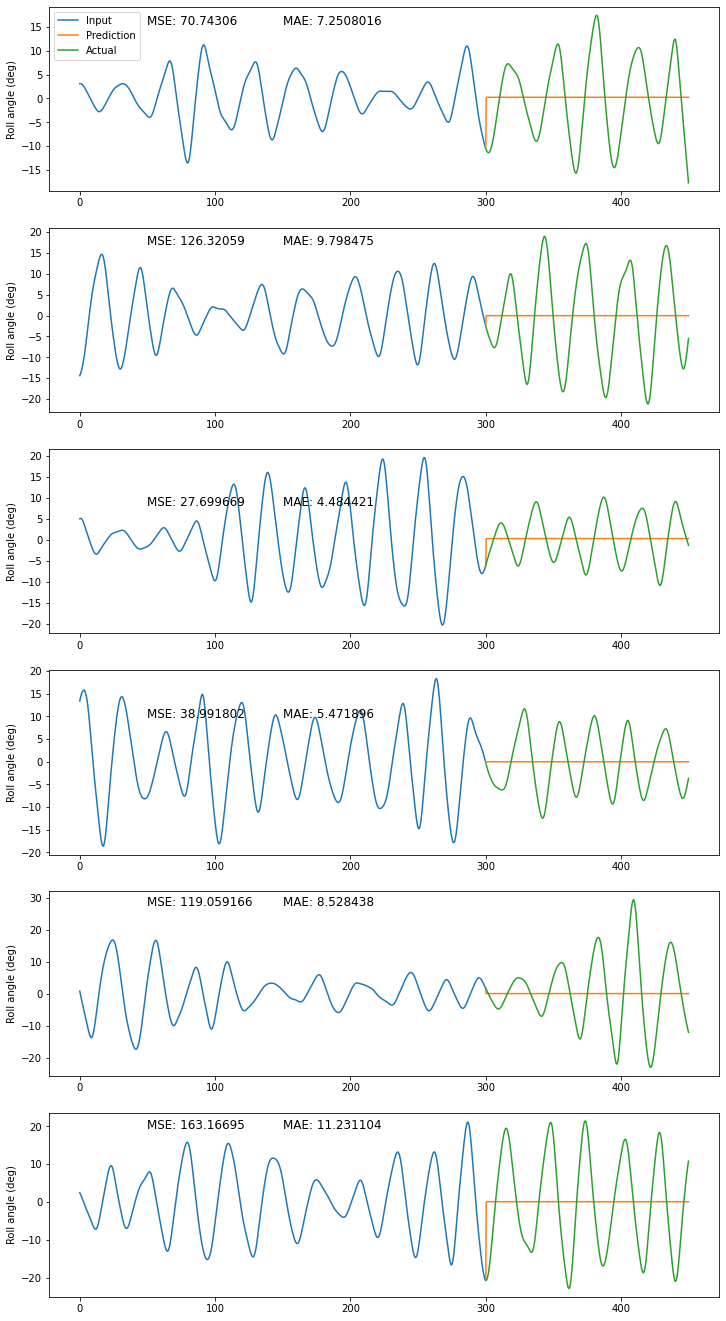

In [24]:
Data.plot_example(50, enc_dec, max_plots=10)

(16, 1200, 1)
tf.Tensor([6.91228834], shape=(1,), dtype=float64)
(16, 600, 1) (16, 600, 1)
tf.Tensor(2.2656617, shape=(), dtype=float32)


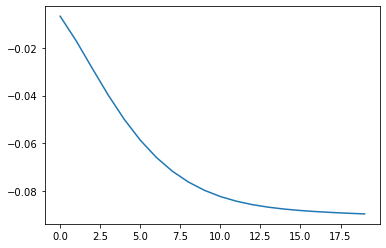

In [188]:
for x, y in Data.Example(50):
    y_pred = enc_dec(x)
    print(x.shape)
    print(max(y[0,:]))
    print(y.shape, y_pred.shape)
    print(MAE(y, y_pred))
    plt.plot(y_pred[0,:20,0], label='y')
    plt.show()
    break

In [26]:
val_performance = enc_dec.evaluate(Data.Val)
test_performance = enc_dec.evaluate(Data.Test)

62/62 [==============================] - 13s 214ms/step - loss: 10.7258 - mean_absolute_percentage_error: 148.9083 - mean_absolute_error: 1.7383


In [27]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 8.95
Validation MAPE:     174.29
Validation MAE:      1.52
Test MSE_loss:       10.73
Test MAPE:           148.91
Test MAE:            1.74
